# Preparación de Datos

In [ ]:
import torch
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from sklearn.datasets import fetch_openml

# mnist = fetch_openml('mnist_784', version=1)
# X, Y = mnist["data"], mnist["target"]

# X.shape, Y.shape

from sklearn.datasets import fetch_openml
import pandas as pd

mnist = pd.read_csv("/content/drive/MyDrive/Datasets/emnist-digits-train.csv")

In [ ]:
# X mayuscula y Y mayuscula contienen los datos de entrenamiento
# o también X_train y Y_train que contienen exactamente lo mismo
X = mnist.iloc[:, 1:].values
Y = mnist.iloc[:, 0].values.ravel()

In [ ]:
# X=X.to_numpy()
# Y=Y.to_numpy()
mnist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239999 entries, 0 to 239998
Columns: 785 entries, 8 to 0.520
dtypes: int64(785)
memory usage: 1.4 GB


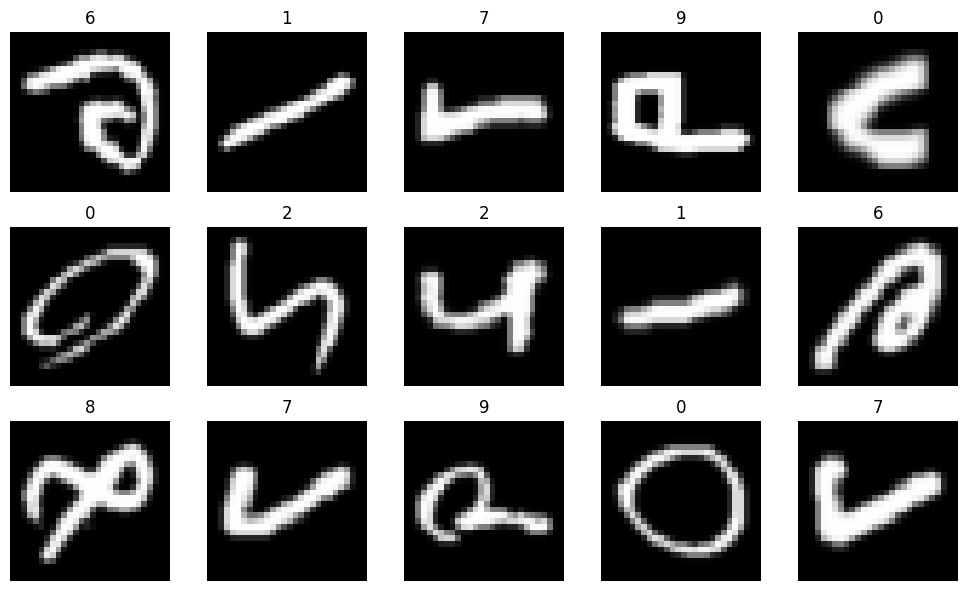

In [ ]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import random

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        img = X[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(Y[ix])
plt.tight_layout()
plt.show()

In [ ]:
X_train = X[:] / 255.
y_train = Y[:].astype(np.int)

<ipython-input-159-7ffa63d83b46>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = Y[:].astype(np.int)


In [ ]:
# X1 y Y1 o X_test y y_test contienen los datos de Testeo
mnist1 = pd.read_csv("/content/drive/MyDrive/Datasets/emnist-digits-test.csv")

X1 = mnist1.iloc[:, 1:].values
Y1 = mnist1.iloc[:, 0].values.ravel()

X_test = X1[:] / 255.
y_test = Y1[:].astype(np.int)

<ipython-input-160-c37f75916302>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test = Y1[:].astype(np.int)


In [ ]:
mnist1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Columns: 785 entries, 0 to 0.481
dtypes: int64(785)
memory usage: 239.6 MB


# Definición de Función de Perdida y Derivada

In [1]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

# Definición de Capas
Contamos con 2 capas ocultas:


1.   100 Neuronas
2.   20 Neuronas



In [ ]:
D_in, H1, H2, D_out = 784, 100, 20, 10

# pesos del MLP (copiamos en gpu)
w1 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_in+H1)),
          size = (D_in, H1)), requires_grad=True, device="cuda", dtype=torch.float)
b1 = torch.zeros(H1, requires_grad=True, device="cuda", dtype=torch.float)

w2 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(H2+H1)),
          size = (H1, H2)), requires_grad=True, device="cuda", dtype=torch.float)
b2 = torch.zeros(H2, requires_grad=True, device="cuda", dtype=torch.float)

w3 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_out+H2)),
          size = (H2, D_out)), requires_grad=True, device="cuda", dtype=torch.float)
b3 = torch.zeros(D_out, requires_grad=True, device="cuda", dtype=torch.float)



X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(y_train).long().cuda()

epochs = 250
lr = 0.7
log_each = 10
l = []
for e in range(1, epochs+1):


    h = X_t.mm(w1) + b1
    h_relu1 = h.clamp(min=0) # relu

    h2 = h_relu1.mm(w2) + b2
    h_relu2 = h2.clamp(min=0) # relu

    y_pred = h_relu2.mm(w3) + b3

    # loss
    loss = cross_entropy(y_pred, Y_t)
    l.append(loss.item())

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    with torch.no_grad():
        # update pesos
        w1 -= lr * w1.grad
        b1 -= lr * b1.grad
        w2 -= lr * w2.grad
        b2 -= lr * b2.grad
        w3 -= lr * w3.grad
        b3 -= lr * b3.grad

        # ponemos a cero los gradientes para la siguiente iteración
        # (sino acumularíamos gradientes)
        w1.grad.zero_()
        w2.grad.zero_()
        w3.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()
        b3.grad.zero_()

    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

Epoch 10/250 Loss 2.47107
Epoch 20/250 Loss 2.30412
Epoch 30/250 Loss 2.11003
Epoch 40/250 Loss 2.02864
Epoch 50/250 Loss 1.95208
Epoch 60/250 Loss 1.86130
Epoch 70/250 Loss 1.73692
Epoch 80/250 Loss 1.60948
Epoch 90/250 Loss 1.48782
Epoch 100/250 Loss 1.37116
Epoch 110/250 Loss 1.27705
Epoch 120/250 Loss 1.19304
Epoch 130/250 Loss 1.13212
Epoch 140/250 Loss 1.06747
Epoch 150/250 Loss 1.01034
Epoch 160/250 Loss 0.95961
Epoch 170/250 Loss 0.91429
Epoch 180/250 Loss 0.87364
Epoch 190/250 Loss 0.84174
Epoch 200/250 Loss 0.80837
Epoch 210/250 Loss 0.77773
Epoch 220/250 Loss 0.74959
Epoch 230/250 Loss 0.72368
Epoch 240/250 Loss 0.69973
Epoch 250/250 Loss 0.67754


In [ ]:
y_pred

tensor([[-4.5927, -3.5253, -2.5690,  ...,  4.9514,  4.3284, 11.9574],
        [ 0.2904, -0.9103,  1.3921,  ..., -3.5797,  0.7235, -1.3394],
        [ 0.1036,  1.4519, -2.9872,  ..., -4.2249,  2.7677,  1.3055],
        ...,
        [-2.5465,  4.2938,  2.0935,  ...,  0.7816,  1.5388,  0.6118],
        [-3.2174,  5.6500,  0.6260,  ...,  1.5229,  2.8394,  2.1475],
        [10.9607, -3.1933,  2.3380,  ..., -2.5494,  1.1285, -0.4456]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
def evaluate(x):
    h = x.mm(w1) + b1
    h_relu1 = h.clamp(min=0)
    h2 = h_relu1.mm(w2) + b2
    h_relu2 = h2.clamp(min=0)
    y_pred = h_relu2.mm(w3) + b3
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.957623940598515

In [ ]:
X_test.shape

(39999, 784)

In [ ]:
Prueba=4161
print(y_test[Prueba])
print(y_pred[Prueba])

2
tensor(2, device='cuda:0')


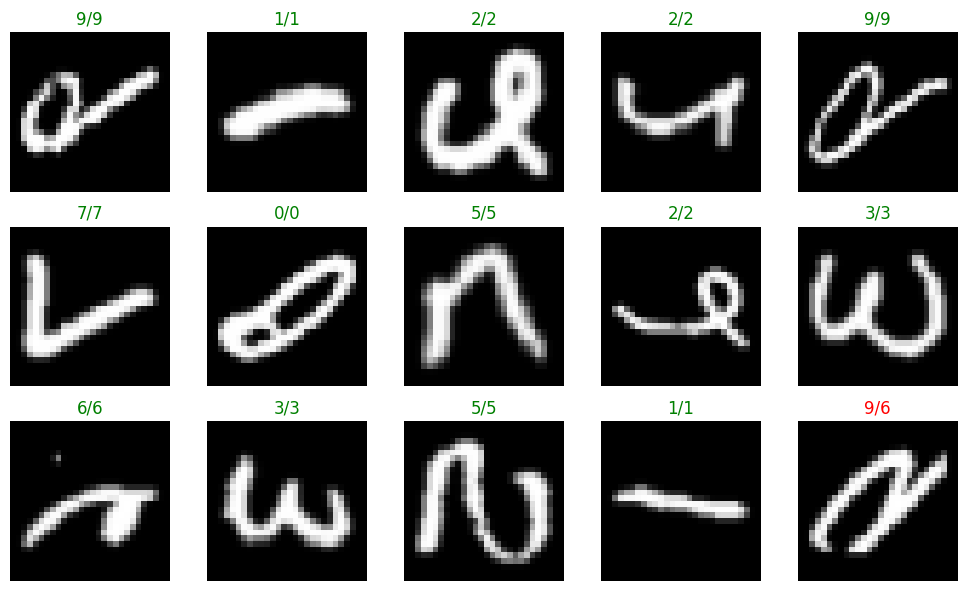

In [ ]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test[ix]
        y_pred = evaluate(torch.tensor([img]).float().cuda())[0]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(f"{y_test[ix]}/{y_pred}", color="green" if y_test[ix] == y_pred else "red")
plt.tight_layout()
plt.show()